In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import thinkstats2

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)

In [2]:
df = pd.read_csv("data/diabetes.csv")
df = df[df["BMI"]>10]
df = df[df["BloodPressure"]>10]
dfD = df[df["Outcome"]==1]
dfN = df[df["Outcome"]==0]
dPos = dfD.BMI
dNeg = dfN.BMI

# No One Test Should Have All This Power

![Kanye](images/kanye.webp "Kanye")

## Errors and Power

Our hypothesis tests are effectively doing a classification - should we trust this effect as significant, or is it likely to be due to chance. In doing this, we introduce errors, two different types:
<ul>
<li>False Positive - The effect is really due to chance, and we've considered it as significant. (Type 1, alpha)
<li>False Negative - The effect is significant, and we've considered it a due to chance. (Type 2, beta)
</ul>
The false positive rate is pretty simple - the threshold rate (commonly .05). We are defining a cutoff at the threshold value - a 1 in 20 criteria means that we expect 1 out of 20 tests to be incorrect - false positive. See book pg 130 for details on how we could show this with CDFs. 
<br><br>
Detecting false negatives isn't as easy...  

<b>Note:</b> The p-value is the number of times we'd expect to see this amount of a difference if the samples are drawn from the same population. 

### Error Types

To deal with this we need to do a quick detour into the different error types, and how each may happen. (We will spend more time with this as we start to do classification models in machine learning)

![Errors](images/class_error_types.png "Confusion Matrix")

The key idea that we can take away from it is that we can be wrong in different ways, and the causes for these mistakes may be different. For example, if we run a hypothesis test and find a p-value of .03, that's an indication that we have about a 3% chance of a false positive - when the difference we see really is due to randomness. This p-value doesn't tell the whole story though, what if we have errors in the other direction - we have differences that do matter, but are being identified as random. Our power measures this - how often are we making these type 2 errors? 



### Power

Power is how the likelihood of a false negative is expressed, in terms of the compliment. The <b>power is the rate of correctly identified negatives</b>, or (1 - False Negatives). We can calculate this with a function from statsmodels, we can also try to generate it (pg131).

First, we'll use the library function. (We also need the effect size - that's what the function will use to estimate how many )

### Load some new data

We are going to attempt to look at the difference in means between male and female age in the sample data below. 

In [3]:
#Load data, do a little filtering
df2 = pd.read_csv("data/oasis_cross-sectional.csv")
df2.drop(columns={"ID", "Hand", "Delay"}, inplace=True)
df2 = df2[df2["CDR"]<2]
df2 = df2[df2["Age"]>60]
males = df2[df2["M/F"]=="M"]
females = df2[df2["M/F"]=="F"]
mAge = males["Age"]
fAge = females["Age"]
df2.head()

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
2,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
11,F,81,5.0,2.0,30.0,0.0,1664,0.679,1.055
13,M,76,2.0,NaN,28.0,0.5,1738,0.719,1.010


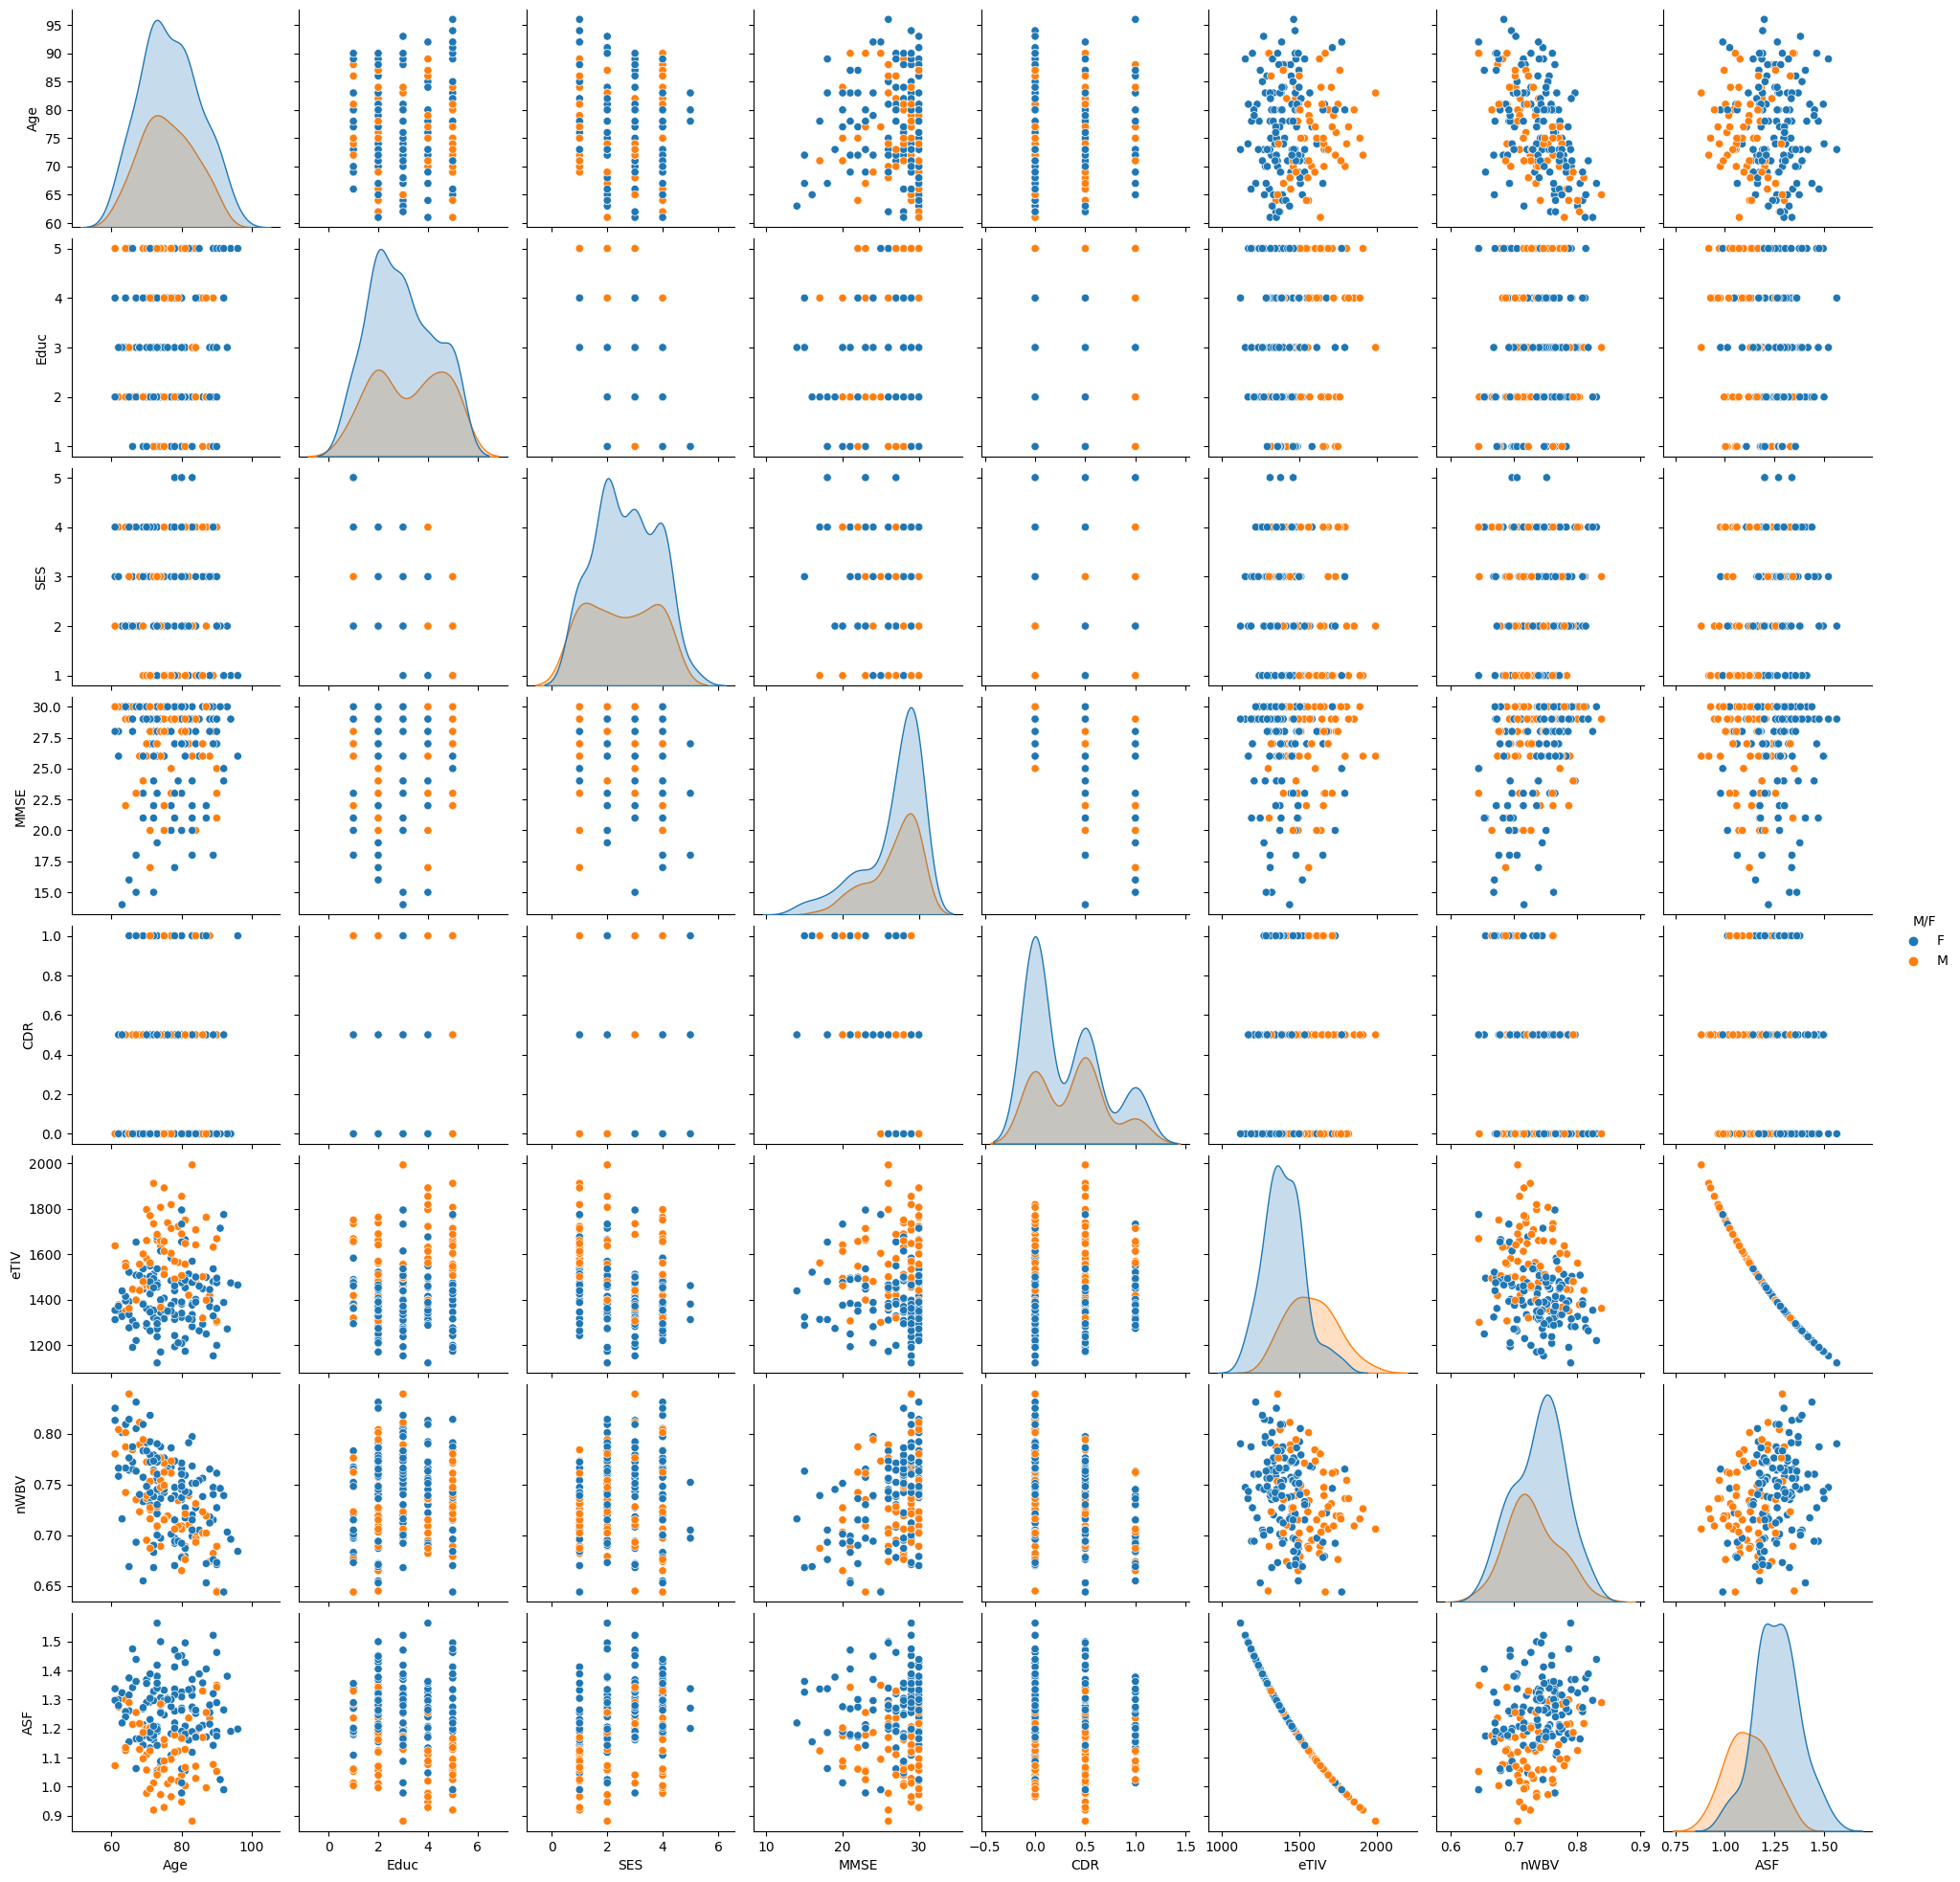

In [4]:
sns.pairplot(df2, hue="M/F")

#### Generate Statistics and Test

In [5]:
#Get Statistics
mMean, fMean, mCount, fCount = mAge.mean(), fAge.mean(), mAge.count(), fAge.count()
mMean, fMean, mCount, fCount

(75.92424242424242, 76.7265625, 66, 128)

There's a difference in means of apx 1 year. Is this significant?

In [6]:
#Scipy ttest:
stat, pval = ss.ttest_ind(mAge, fAge)
pval

0.5077810125785922

### Test Power

It appears that this difference is likely due to chance, the p value is high. How powerful is our test?

In [7]:
#Statsmodels calculation of power. 
from statsmodels.stats.power import TTestPower
powerTest = TTestPower()
ces = thinkstats2.CohenEffectSize(fAge, mAge)
alpha = .05
nobs = mCount + fCount

pow = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
pow, ces


(0.28602587493138343, 0.10056623784128305)

What did we get? Our power is small, this is an indication that we are making a lot of potential mistakes here.

This helps indicate that our asserion of an effect here is likely due to chance. 

<b>In general, powers of over 80% are considered "good", as a rule of thumb. </b>

If you're working through the book examples, think about how this relates. The book is building a loop to, by hand, count up the number of false negatives. They then to 1-that to get the power - same, same, but a different approach. 

#### Power Test #2

One more.... The old BMI one from last time...

In [8]:
#Get some basic stats for the diabetes data
meanPos, stdPos, varPos, nPos = dPos.mean(), dPos.std(), dPos.var(), dPos.count()
meanNeg, stdNeg, varNeg, nNeg = dNeg.mean(), dNeg.std(), dNeg.var(), dNeg.count()

In [9]:
#ttest
# This is one sided - a test of if pos is greater than neg, not just different
sstat, pval = ss.ttest_ind(dPos, dNeg, alternative="greater")
pval

2.717898126321664e-17

P value is really, really small. The effect is likely not due to random chance. What is the power of this one?

In [10]:
#Statsmodels calculation of power. 
ces2 = thinkstats2.CohenEffectSize(dPos, dNeg)
alpha2 = .05
nobs2 = nNeg + nPos

pow2 = powerTest.power(effect_size=ces2, nobs=nobs2, alpha=alpha2)
pow2, ces2

(1.0, 0.6692882815710599)

#### Calculate Sample Size

We can also use the power functionality to back calculate the needed sample size to reach the desired level of confidence. More accurately, we can leave any of the inputs - effect size, sample size, alpha, and power - out and this will calculate that value for us.

So here we'd need about ~780 records, with an effect size that large, to be able to run a hypothesis test that yeilds p<=.05 and a power of 80%. 

In [11]:
#Calculate n
n = powerTest.solve_power(ces, power=.8, nobs=None, alpha=alpha)
n

777.9952630145431

Huge power. That makes sense, our effect size is substantial and the p-value is extremely low. 1.0 is a bit of a stretch as an assertion, due to randomness - this result would likely be more accurately reported as 'near 1' or >.99 or something like that. Our trial could have a false negative, it is just unlikely. Our run happened to just not have any. 

## Tests and Conclusions

We've seen a multitude of different ways that we can look at data and attempt to evaluate if a difference between samples is real. Which one is the one we use? None of these tests are definitive, so what we want to see is allignment of multiple of the tests. In general, if we are looking at a real difference, we expect to see a noticable effect size, a low p-value in a t-test, and large power all alligning - we are not so much concerned with a specific cutoff, but if all of the ways of looking at the samples seem to indicate something similar, such as a difference, then we can be quite confident that what we are seeing is real. 

## What About Categorical Data - Chi-2 Tests

We can also mix up the tests a little bit to look at things a little differently. One example is dealing with categorical data and proportions - the chi squared test. Chi2 calculates relationships between categorical varaibles by looking at the difference between an expected number of observations, and the real number of observations. The other stuff in here generally looks at differences in the means of numerical values, chi2 looks at counts of categorical. 

In the book 9.7 there's an example of using chi2 to perform a huypothesis test on a proportion. 

Later on in machine learning stuff, this chi2 concept is used to try to determine which categorical features are useful in a model, similarly to how correlation is used with numerical varaibles. 

#### Dice Rolls

The heart of chi2 is calculating how big of a differnce there is between the counts that we'd expect, and the counts that we observe. For this example here we have a die that we've rolled 60 time, if the die is fair, the expected results would be even - 10 rolls per number. This is represented by the expected list below. If we count up the actual rolls, we observe a difference in counts, this is shown in the observed list. We want to know if this is reasonably likely to be due to random chance, or if this is likely a real effect (i.e. a rigged die). The chi2 gives us a p-value and all the same logic applies with testing that p. 

In [12]:
#Scipy chi2
# Counts of roll by number
# I.E. # of 1s rolled, # of 2s rolled, etc....
expected = [10,10,10,10,10,10]
observed = [8,9,19,5,8,11]
ss.chisquare(observed, expected)

Power_divergenceResult(statistic=11.6, pvalue=0.040699388504049985)

P value is just below the cutoff of .05. We may well be getting scammed...

In [13]:
#Slightly more fair example
#if the expectations are even, we can leave out the expectations, they'll be assumed
observed2 = [9,11,12,9,9,10]
ss.chisquare(observed2)

Power_divergenceResult(statistic=0.8, pvalue=0.9770333437569263)

We see that the p-value is high, a difference this small is almost certainly due to chance. 

#### Exercise - Cards

You're in charge of security at a casino. You are watching a blackjack dealer who you think may be corrupt. You notice that for certain players, they appear to be getting winning cards more often than you'd expect. Specifically, those players look like they are getting Aces, and 10 value cards (K,Q,J,10) pretty frequently, and this is resulting in those players winning quite a bit of money. You observe 780 hands and count the number of high value cards they players receive from the dealer. Your counts are as follows:
<ul>
<li>Observed 74 Aces, 250 "10 cards", 456 cards 9 and below. 
<li>Expectation - there are 52 cards in each deck, 4 of each value (A, K, Q, J, 10, etc...). The game is played with many decks and they are reshuffled partway though, so you can approximate the odds of any given value being drawn as 1/13. 
</ul>
Is this game biased?

In [14]:
#350 total draws
#Aces, 10 cards, others
observed3 = [74,250,456]
expected3 = [60,240,480]
ss.chisquare(observed3, expected3)

Power_divergenceResult(statistic=4.883333333333333, pvalue=0.08701570436572376)

## What if There's 3 or More Samples? 

We can use ANOVA - analysis of varaince. Anova is short for analysis of variance, and can kind of be thought of as a 3+ way ttest. Again, we are going to look if there appears to be a significant difference in the means of any of the groups. We form our hypothesis as follows:
<ul>
<li>Null Hypothesis - all the groups have the same mean.
<li>Alternative Hyp. - at least one of the groups has a different mean
</ul>
<b>Note:</b> - this will only give us and indication if one group is different from the others, it won't generate a list of all the differences in descending order or anything that fancy. 

ANOVA is a parametric test with a few assumptions:
<ul>
<li>The data is independent - observations are only in one group.
<li>The data is normal.
<li>Variances are close to equal.
</ul>

We can try to test this with the current data, we'll look for if there's a substantial differences in the Age between groups with different levels of education. 

ANOVA type of analysis can be well illustrated using a chart called a boxplot. Remember - the goal of these tests is to look for differences in the means of different samples, we can eyball that pretty well with one of these charts.

In [26]:
df2.Educ.value_counts()

2.0    59
3.0    39
5.0    38
4.0    36
1.0    22
Name: Educ, dtype: int64

<AxesSubplot: xlabel='Educ', ylabel='Age'>

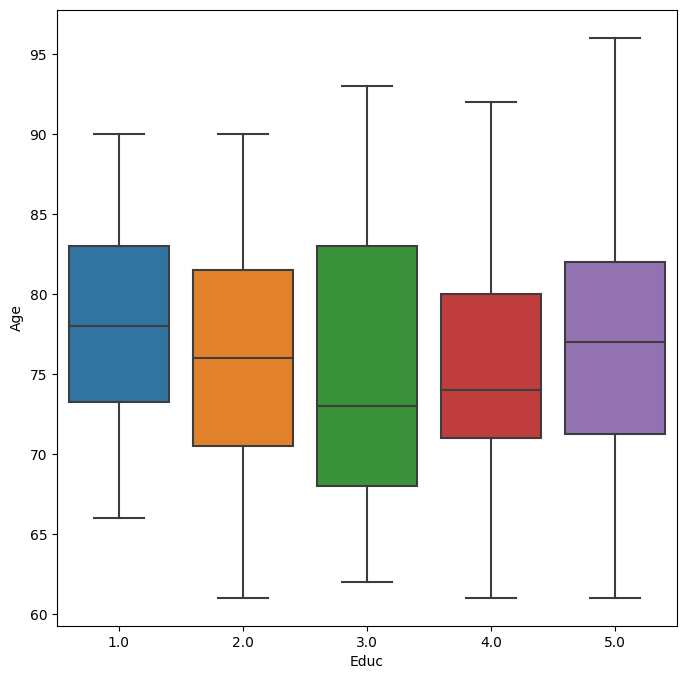

In [15]:
#Make a boxplot to demonstrate. 
sns.boxplot(data=df2, x="Educ", y="Age")

### Variance Test

We need to check the varaiances to be sure that this is going to work OK. We can run another test from scipy, called the Levene test. This test will evaluate if the varaiances of all the groups provided are equal, or if one (or more) of them differs. The null hypothesis that we are testing is "there is no difference between the varaiances of the groups". 

In [16]:
#First, test for vars being equal-ish
varStat, varP = ss.levene(df2['Age'][df2['Educ'] == 1],
               df2['Age'][df2['Educ'] == 2],
               df2['Age'][df2['Educ'] == 3],
               df2['Age'][df2['Educ'] == 4],
               df2['Age'][df2['Educ'] == 5])
varP

0.7071382063804008

The "are the variances equal" question that we calculate with the levene test above is another hypothesis test. It returns a p-value that we can use to reject/accept the NH. In this case, p is high, so we can't reject the NH, and the varaiances are likely pretty similar. Yay! 

The formula name is because ANOVA uses what's called an f-statistic to do its analysis. F is a ratio of two varainaces, so that's where the ANOVA name comes from. It is analyzing the variation within each sample to the variation between samples. We get back that f statistic and the p value. 

<b> F = var between samples / var within samples </b>

In [17]:
#
ss.f_oneway(df2['Age'][df2['Educ'] == 1],
               df2['Age'][df2['Educ'] == 2],
               df2['Age'][df2['Educ'] == 3],
               df2['Age'][df2['Educ'] == 4],
               df2['Age'][df2['Educ'] == 5])

F_onewayResult(statistic=0.9489002702553063, pvalue=0.43691320162590475)

P value is high, we can't reject the NH, so the means between the groups appears to be equal. Looking at F, that makes sense, if we found that the samples varried from each other, that ratio would be way higher. This relationship generally holds true. 

### Exercise

Try to use any other data we have used that has 3+ categories. Slice the data and do an ANOVA on it to see if the means vary.

<AxesSubplot: xlabel='SES', ylabel='Age'>

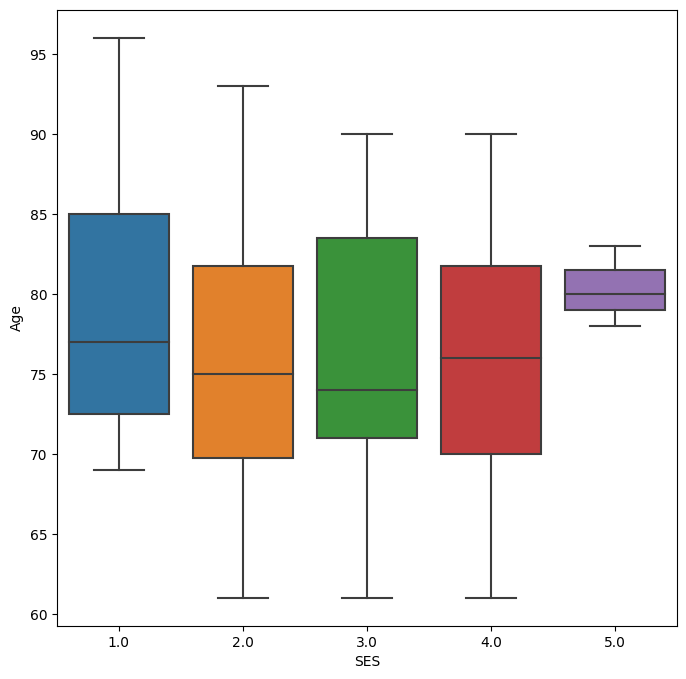

In [18]:
# I will split based on the SES value

sns.boxplot(data=df2, x="SES", y="Age")

Check the varaiances... 

In [19]:
print(np.var(df2['Age'][df2['SES'] == 1.0]))
print(np.var(df2['Age'][df2['SES'] == 2.0]))
print(np.var(df2['Age'][df2['SES'] == 3.0]))
print(np.var(df2['Age'][df2['SES'] == 4.0]))
print(np.var(df2['Age'][df2['SES'] == 5.0]))

59.090612244897954
62.17000000000001
67.95918367346938
61.9305293005671
4.222222222222222


In [20]:
#First, test for vars being equal-ish
varStat, varP = ss.levene(df2['Age'][df2['SES'] == 1.0],
               df2['Age'][df2['SES'] == 2.0],
               df2['Age'][df2['SES'] == 3.0],
               df2['Age'][df2['SES'] == 4.0],
               df2['Age'][df2['SES'] == 5.0])
varP

0.44572087232472135

The levene test passes with all the data, but the raw value and the box-plot examination make it look a bit different for one group. It appears that group #5 is different in its variance. Maybe we can remove that one, and look at the other 4.

In [21]:
#First, test for vars being equal-ish
varStat, varP = ss.levene(df2['Age'][df2['SES'] == 1.0],
               df2['Age'][df2['SES'] == 2.0],
               df2['Age'][df2['SES'] == 3.0],
               df2['Age'][df2['SES'] == 4.0])
varP

0.9626874202437752

With the odd group removed, the test pvalue jumps massively. Now the datasets have very similar variances, we can go ANOVA on it. 

In [22]:
stat, pval = ss.f_oneway(df2['Age'][df2['SES'] == 1.0],
               df2['Age'][df2['SES'] == 2.0],
               df2['Age'][df2['SES'] == 3.0],
               df2['Age'][df2['SES'] == 4.0])
stat, pval

(1.4031343834576209, 0.24367454498017793)

## What if the Data Isn't Normal?

The above tests have an assumption that the data is normal. What if it isn't? For non-normal data we need a different type of test, such as Mann-Whitney. 

Statistical tests that are non-parametric, in general, work in the same way as the ones we've been using. What we are losing is normally some degree of reliability - the parametric tests use the knowledge of the distributions in generating their answers. Tests like this M-W one don't have those assumptions to lean on, so they are generally not able to be as great. If the data fits a pattern, usually a normal one, or is easily transformed into normal, the parametric tests will probably be a better choice. 

#### Mann-Whitney - Non-Parametric T-Test

We can try one here, the mechanics are not much different. 

<AxesSubplot: xlabel='CDR', ylabel='Density'>

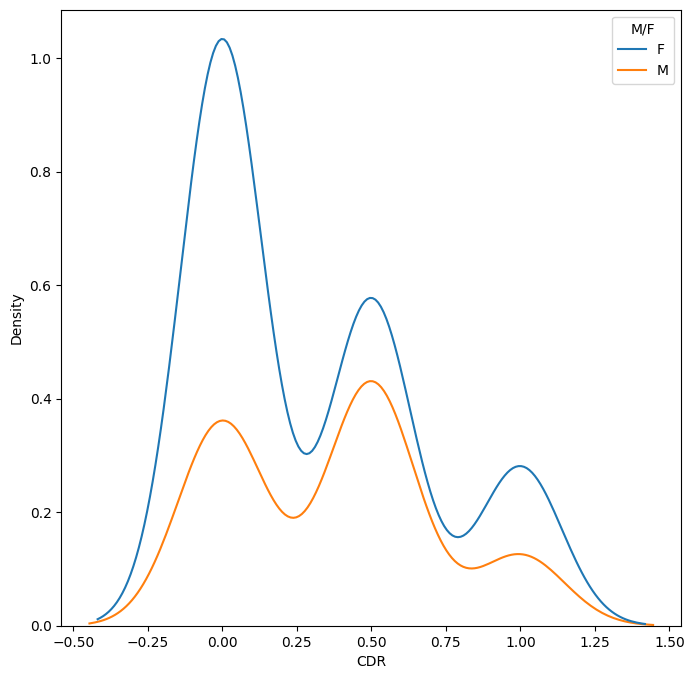

In [23]:
sns.kdeplot(data=df2, x="CDR", hue="M/F")

The value CDR when split M/F have some pretty not-normal distributions. They also seem to follow the same pattern, but in distinctly different ways - a perfect opportunity for a non-parametric ttest - FINALLY!!!

In [24]:
cdr_m = df2['CDR'][df2['M/F'] == "M"]
cdr_f = df2['CDR'][df2['M/F'] == "F"]

ss.mannwhitneyu(cdr_m, cdr_f)

MannwhitneyuResult(statistic=4751.0, pvalue=0.11856606407740058)

##### Results 

P-value understanding is the same, is is fairly unlikely for the difference here to be due to randomness. 